In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [2]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [3]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [5]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=512, 
                                        num_workers=6,
                                        shuffle=True
                                        )
                                        
images,labels = next(iter(loader))

In [7]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

In [8]:
images = torch.zeros((n_classes,1,_N,_N))

for imgs,lbls in train_loader:
    for img,lbl in zip(imgs,lbls):
        images[lbl] = img

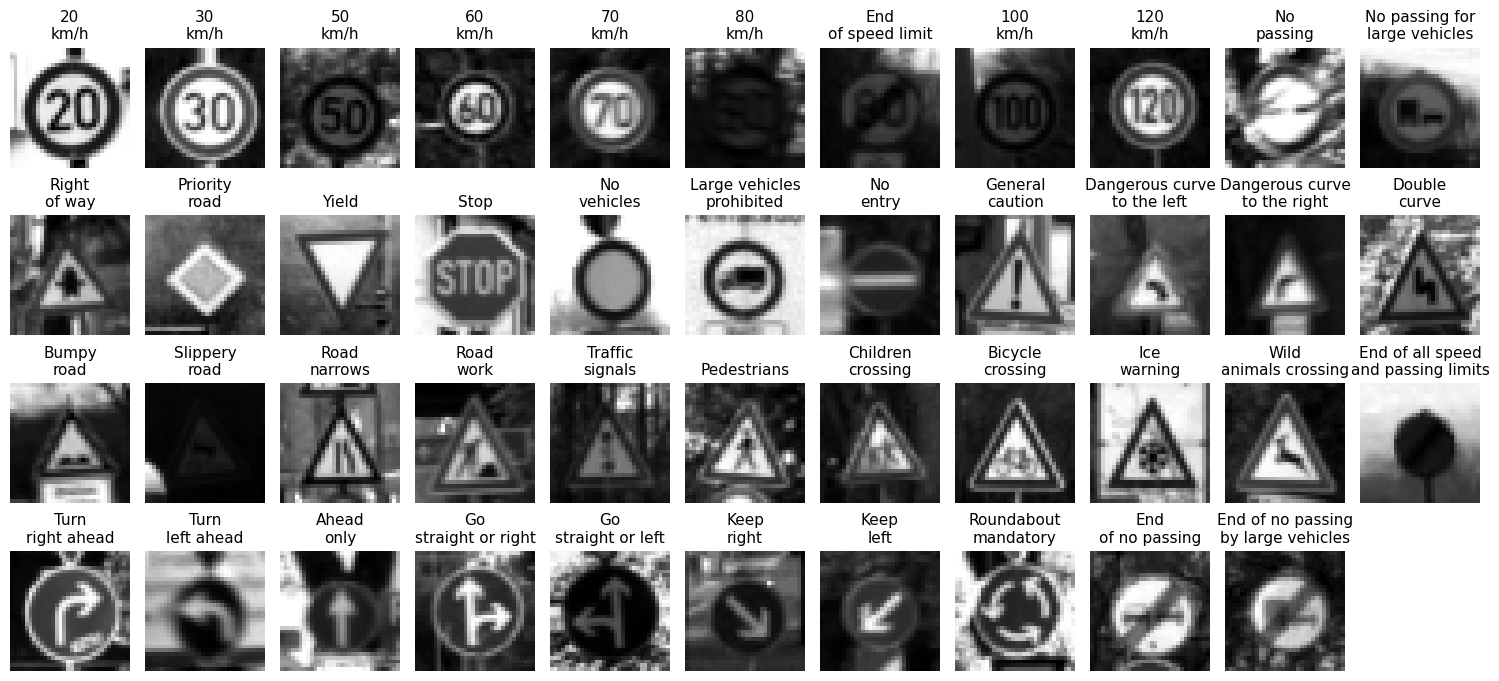

In [9]:
plt.rc('axes', titlesize=11)


plt.figure(figsize=(15,7))

    
for i, img in enumerate(images):
    name = LABELS[i]
    if len(name) > 24:
        name = name[:12] + name[12:].replace(" ","\n",1)
    else:
        name = name.replace(" ","\n",1)
    plt.subplot(4,11, i + 1)
    plt.imshow(to_image(img),cmap="grey")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()

In [10]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.AvgPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],120)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],80)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)

In [11]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [12]:
def evaluate(model,epsilon):
    predictions = []
    labels = []
    cs = 0

    for images,lbls in test_loader:
        labels.extend(lbls.numpy())
        
        images = images.to(device)
        preds = model(images)
        predictions.extend(preds.cpu().detach().numpy())
        cs += constraint_security(model,images,lbls,epsilon,loss_func)
            
    cs /= len(test_loader)

            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    accuracy = accuracy_score(labels,pred_class)
    print(f"Accuracy: {accuracy:.2f}")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
    print(f"Constraint Security: {cs:.4f}")

In [13]:
def constraint_security(model,images,labels,epsilon,loss_func):
    decay_rate = 6
    learning_rate = 40 / 255
    momentum_decay = 0.8
    iterations = 40
    adv = pgd_attack(model,images.to(device),labels.to(device),loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
    pred = torch.argmax(model(adv),dim=1)
    return accuracy_score(labels.cpu(),pred.cpu())

In [14]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(decay_rate,1,iterations,2)
    decay = decay / decay[0]
    decay *= learning_rate
    
    momentum = torch.zeros(images.shape).to(device)

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations + momentum) * alpha

        momentum = momentum * momentum_decay + (1 - momentum_decay) * perturbations

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)

normalise.to(device)
@torch.compile
def denormalise(images):
    return images * std + mean

In [15]:
epsilon = 5 / 255
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_0.pth"))
evaluate(model,epsilon)

Accuracy: 0.99
Precision (macro): 0.9882
Recall (macro): 0.9878
F1-score (macro): 0.9877
Constraint Security: 0.2452


In [16]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_5.pth",weights_only=True))
evaluate(model,epsilon)

Accuracy: 0.98
Precision (macro): 0.9811
Recall (macro): 0.9802
F1-score (macro): 0.9803
Constraint Security: 0.7011


In [17]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_10.pth",weights_only=True))
evaluate(model,epsilon)

Accuracy: 0.93
Precision (macro): 0.9389
Recall (macro): 0.9268
F1-score (macro): 0.9286
Constraint Security: 0.7429


In [18]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_15.pth",weights_only=True))
evaluate(model,epsilon)

Accuracy: 0.86
Precision (macro): 0.9010
Recall (macro): 0.8574
F1-score (macro): 0.8691
Constraint Security: 0.6998


In [19]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_20.pth",weights_only=True))
evaluate(model,epsilon)

Accuracy: 0.78
Precision (macro): 0.8822
Recall (macro): 0.7814
F1-score (macro): 0.8065
Constraint Security: 0.6830
